# Introduction

L'apprentissage fédéré (FL), proposé par Google au tout début, est récemment un domaine de recherche en plein essor de l'apprentissage automatique, qui vise à protéger la confidentialité des données individuelles dans les processus d'apprentissage automatique distribués, en particulier dans la ﬁnance, les soins de santé intelligents et l'edge computing. Différents de l'apprentissage automatique distribué traditionnel centré sur les données, les participants dans le cadre du FL utilisent des données localisées pour former des modèles locaux, puis exploitent des stratégies spéciﬁcales avec d'autres participants pour acquérir le modèle ﬁnal de manière collaborative, en évitant un comportement de partage direct des données.

<img src='images\FL.png'>

Durant ce TP, nous allons implementer une tâche de classification sur l'ensemble des données MNIST en utilisant les algorithmes FedAVG et FedProx de l'apprentissage fédéré

# 1. Importation des packages

Nous allons travailler avec les package suivant:
- PyTorch : PyTorch est une bibliothèque logicielle Python open source d'apprentissage automatique qui s'appuie sur Torch, développée par Meta. PyTorch permet d'effectuer les calculs tensoriels nécessaires notamment pour l'apprentissage profond (deep learning). Ces calculs sont optimisés et effectués soit par le processeur (CPU) soit, lorsque c'est possible, par un processeur graphique (GPU) supportant CUDA.
- NumPy : NumPy est une bibliothèque pour langage de programmation Python, destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
- Matplotlib :  Matplotlib est une bibliothèque du langage de programmation Python destinée à tracer et visualiser des données sous forme de graphiques

In [23]:
import torch
import random
from torchvision import datasets, transforms
import numpy as np
from copy import deepcopy
import copy
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
import timeit
import pandas as pd

# 2. Lecture des données

L'ensemble de données utilisé est MNIST Handwritten Digit Classification Dataset. Il s'agit d'un jeu de données de 60 000 petites images carrées en niveaux de gris de 28×28 pixels représentant des chiffres uniques manuscrits compris entre 0 et 9.

La tâche qui sera implementé consiste à classer une image donnée d'un chiffre manuscrit dans l'une des 10 classes représentant les valeurs entières de 0 à 9, inclusivement.

Torchvision fournit de nombreux jeux de données intégrés dans le module torchvision.datasets, ainsi que des classes utilitaires pour construire vos propres jeux de données. On va utiliser **torchvision.datasets** pour obtenir le jeu de données de MNIST (qui sera enregistré dans le répartoire *data/mnist/*) comme suit :

In [24]:
# Normaliser les images de MNIST
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Ensemble d'entrainement
dataset = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)

# Ensemble de de test
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

In [25]:
print("Le nombre de données d'entrainement : ", len(dataset))

Le nombre de données d'entrainement :  60000


In [26]:
print("La taille d'une image est de : ", list(dataset[0][0].shape))

La taille d'une image est de :  [1, 28, 28]


**Question** : Dans quel niveau de couleur les images sont-elles représentées ?  ***(1 pt)***  
**Réponse** : Gris

Visualisons maintenant une image de l'ensemble d'entrainement

In [69]:
def afficher_images(data, n_row, n_col):
    """
        Cette fonction permet d'afficher n_row*n_col de l'ensemble data
    """

    plt.figure(figsize=(6, 6))
    all_idxs = np.arange(len(dataset))

    for j in range(1, n_row*n_col + 1):
        plt.subplot(n_row, n_col, j)
        indx_img = int(np.random.choice(all_idxs, 1, replace=False))
        image = data[indx_img][0].reshape([28, 28])

        plt.imshow(image, cmap = "gray")
        plt.axis('off')

        all_idxs = list(set(all_idxs) - {indx_img})


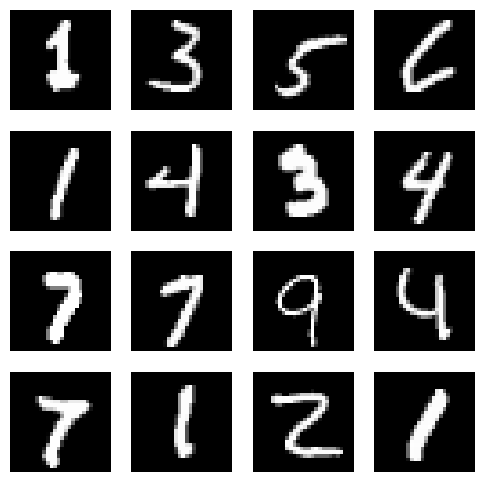

In [70]:
afficher_images(dataset,4, 4)

# 3. Répartition des données

Dans la littérature il existe deux façons pour partitionner les données sur un ensemble de participants, on retrouve :

- IID : Données indépendants et identiquement distribués.
- Non IID : Données non indépendants et identiquement distribués.

L'apprentissage fédéré généralement travaille avec des données non iid . C'est pour cette raison que la majorité des algorithmes d'apprentissage fédéré vérifie leur efficacité avec des ensemble de données non IID

subset_dataset est une classe qui nous permet d'extraire une partie d'un dataset et le manipuler facilement (noter qu'elle hérite de **torch.utils.data.Dataset**)

In [29]:
class subset_dataset(Dataset):
    """
    Sous-ensemble d'un ensemble de données aux indices spécifiés.

    Arguments :
        dataset (Ensemble de données) : Le jeu de données complet
        indices (séquence) : Indices dans l'ensemble entier sélectionnés pour le sous-ensemble
        labels(sequence) : cibles comme requis pour les indices. seront de la même longueur que les indices
    """
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

Commencons par implementer la fonction **division_iid**. Elle prend comme parametre :
- dataset : l'ensemble de données
- num_clients : le nombre de clients dont l'ensemble de données sera divisé
- initial : on aura besoin de ce champ pour affecter un nom à chaque client, par example si initial = "client", les clients auront les noms : client_1, client_2 ... etc

Chaque client recevera d'une manière aléatoire **len(dataset)/num_clients)** example d'entrainement


**Completer le code suivant dans les cases appropriées** ***(1 pt)***

In [30]:
def division_iid(dataset, num_clients, initial = "client"):
    """
    Extraire de données de clients I.I.D. à partir d'un ensemble de données
    return : dict des donnés des clients
    """

    ### YOUR CODE HERE ###
    # Hint : num_items : va contenir le nombre de données dévisé de manière équitable pour chaque client
    num_items = len(dataset) // num_clients
    ### END OF YOUR CODE ###

    dict_users, all_idxs = {}, np.arange(len(dataset))

    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    for i in range(num_clients):

        ### YOUR CODE HERE ###
        # Hint : choisir de manire alétoire num_items de all_indx
        idx_clienti = np.random.choice(all_idxs, num_items, replace=False)
        ### END OF YOUR CODE ###

        labels_clienti = [dataset[i][1] for i in idx_clienti]

        dict_users[client_names[i]] = subset_dataset(dataset, idx_clienti,labels_clienti)
        all_idxs = list(set(all_idxs) - set(idx_clienti))

    return dict_users


Pour tester notre fonction, divisons l'ensemble de données **dataset** sur 10 clients de manière IID

In [31]:
dict_usersiid = division_iid(dataset, 10, initial = "client")
dict_usersiid

{'client_1': <__main__.subset_dataset at 0x7d759f827760>,
 'client_2': <__main__.subset_dataset at 0x7d759c5dafe0>,
 'client_3': <__main__.subset_dataset at 0x7d759c5dbfd0>,
 'client_4': <__main__.subset_dataset at 0x7d759c5dbcd0>,
 'client_5': <__main__.subset_dataset at 0x7d759c5daf80>,
 'client_6': <__main__.subset_dataset at 0x7d759c5db0d0>,
 'client_7': <__main__.subset_dataset at 0x7d759c5dab60>,
 'client_8': <__main__.subset_dataset at 0x7d759c5db160>,
 'client_9': <__main__.subset_dataset at 0x7d759c5db9a0>,
 'client_10': <__main__.subset_dataset at 0x7d759c5db100>}

Afin d'afficher le nombre de données distribuées sur chaque classe pour un client donné (cela nous va permettre de mieux visualiser la notion de données IID), nous utilisons la fonction suivante :

In [32]:
def afficher_class(dict_users, client_name, num_class):
    # une liste qui contient les index des données locale du client client_name
    idxs = np.arange(len(dict_users[client_name]))

    # une liste qui contient les labels de chaque image de l'ensemble locale du client_name
    labels = dict_users[client_name].targets

    # Ordonner les données par rapport à label afin d'utiliser la fonction extract de numpy
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]

    idxs = idxs_labels[0]
    labels = idxs_labels[1]

    unique_labels = np.arange(num_class)
    nombre_donneesClasse = []

    for i in unique_labels:
        nombre_donneesClasse.append(len(np.extract(labels == i, idxs)))

    plt.bar(unique_labels, nombre_donneesClasse, color = '#0000FF' )
    plt.ylabel("Nombre de données")
    plt.xlabel("Numéro de la classe")
    plt.title("Histogramme")

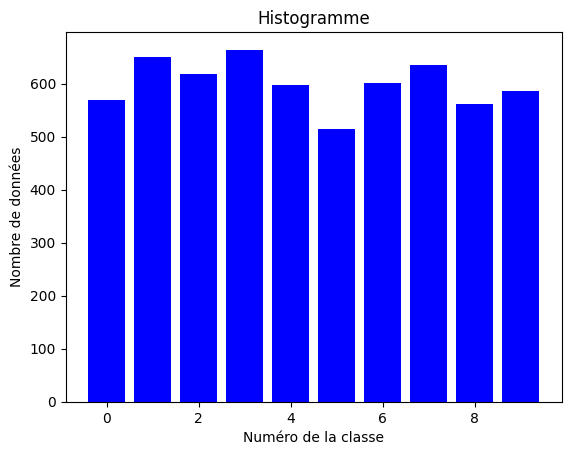

In [33]:
afficher_class(dict_usersiid, "client_1", 10)

**Question** : Que remarquez vous ?  ***(1 pt)***
**Réponse** : Le nombre des items pour chaque classe est légèrement différente, donc il s'agit des données équitablement distribué.

Passons maintenant à la fonction division_noniid. Elle prend comme parametre :

- dataset : l'ensemble de données
- num_class_partage : Le nombre de classes que chaque client peut exactement contenir, par exemple si num class partage = 2, le client i doit contenir les images de deux classes.
- num_intra_clients : le nombre de client pour chaque num_class_partage


**Completer le code suivant dans les cases appropriées** ***(3 pt)***

In [34]:
def division_noniid(dataset, num_classe_partage, num_intra_clients):
    """
    Extraire de données de clients I.I.D. à partir d'un ensemble de données
    return : dict des donnés des clients
    """

    all_idxs = np.arange(len(dataset))
    dict_users, all_idxs = dict(), np.arange(len(dataset))
    labels = np.array(dataset.targets)

    idxs_labels = np.vstack((all_idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]

    unique_labels = np.unique(np.array(labels))
    # on mélange les labels pour que le résultat finale ne soit pas biasé
    random.shuffle(unique_labels)

    all_idxs = idxs_labels[0]
    labels = idxs_labels[1]

    sub_lab_list = [unique_labels[i:i + num_classe_partage] for i in range(0, len(unique_labels), num_classe_partage)]

    for item in sub_lab_list:

        idx_clienti = np.extract([labels[i] in item for i in range(len(labels))], all_idxs)
        labels_clienti = [dataset[i][1] for i in idx_clienti]


        # Creation du nom de chaque client
        initial = 'client'
        for lab in item:
            initial = initial + str(lab) + '_'

        # Pour les clients intraclass la division sera iid donc on utilisera la fonction qu'on a déja implementé et on utilise aussi la classe subset_dataset

        ### YOUR CODE HERE ###
        # Hint : remplir l'argument de la fonction division_iid
        intraclass_clients = division_iid(dataset=subset_dataset(dataset, idx_clienti, labels_clienti),
                                 num_clients=num_intra_clients,
                                 initial=initial)
        ### END OF YOUR CODE ###

        dict_users.update(intraclass_clients)

    return dict_users

Pour tester notre fonction, divisons l'ensemble de données dataset sur 10 clients de manière non-IID tel que :
- Pour chaque deux classe (deux labels des images par example : 4 et 8) construire 2 clients de manière IID

On aura ainsi (10/2) * 2 = 10 clients

In [35]:
dict_users_non_iid = division_noniid(dataset, 2, 2)
dict_users_non_iid

{'client3_9__1': <__main__.subset_dataset at 0x7d759c940310>,
 'client3_9__2': <__main__.subset_dataset at 0x7d759c940460>,
 'client6_4__1': <__main__.subset_dataset at 0x7d759c940040>,
 'client6_4__2': <__main__.subset_dataset at 0x7d759c941750>,
 'client1_0__1': <__main__.subset_dataset at 0x7d759c9417b0>,
 'client1_0__2': <__main__.subset_dataset at 0x7d759c941810>,
 'client5_7__1': <__main__.subset_dataset at 0x7d759c941c60>,
 'client5_7__2': <__main__.subset_dataset at 0x7d759c941c30>,
 'client2_8__1': <__main__.subset_dataset at 0x7d759c941c90>,
 'client2_8__2': <__main__.subset_dataset at 0x7d759c941ea0>}

client8_6__1 : le client numéro 1 contenant des images de labels 8 et 6

Afin d'afficher le nombre de données distribuées sur chaque classe pour un client donné, nous alons utilisé la fonction déja implementée :

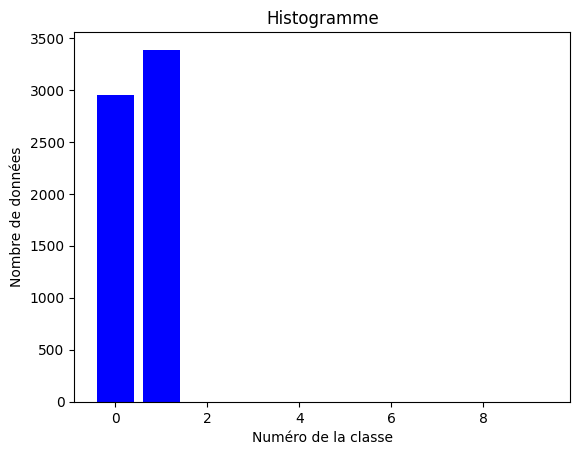

In [36]:
afficher_class(dict_users_non_iid, "client1_0__1", 10)

**Question** : Que remarquez vous ?  ***(1 pt)***  
**Réponse** :
Les données ne sont pas réparties de manière équitable entre toutes les classes, mais plutôt entre seulement deux classes en raison du paramètre num_class_partage, qui est fixé à 2.

# 4. Création du modèle

Dans cette section nous allons implémenter le modèle d'apprentissage automatique utilisé.
On va utiliser un Cnn (convolutional neural network) avec deux couches convolutif 5*s5 avec 6 et 16 canaux respectivement. Suivi chacune par un MaxPooling 2*2 et deux couches entièrement connectées une avec 120 et 84 noeuds respectivement. Et enfin une couche de sortie avec 10 noeuds.

In [37]:
class CNN(nn.Module):
    def __init__(self, num_channels, out_channels1, out_channels2, num_classes):

        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = out_channels1, kernel_size=5, stride = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.conv2 = nn.Conv2d(in_channels = out_channels1, out_channels = out_channels2, kernel_size=5, stride = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)


        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self,x):
        #first Convolutional layers
        x=self.conv1(x)
        #activation function
        x=torch.relu(x)
        #max pooling
        x=self.maxpool1(x)
        #first Convolutional layers
        x=self.conv2(x)
        #activation function
        x=torch.relu(x)
        #max pooling
        x=self.maxpool2(x)
        #flatten output
        x= torch.flatten(x,1)
        #fully connected layer 1
        x=self.fc1(x)
        #activation function
        x = torch.relu(x)
        #fully connected layer 2
        x= self.fc2(x)
        #activation function
        x = torch.relu(x)
        #fully connected layer 3
        x= self.fc3(x)

        return x

In [38]:
model = CNN(num_channels =1,  out_channels1=6, out_channels2 = 16, num_classes = 10)
print(" Les parametres du modèle sont les suivants : ", list(model.state_dict().keys()))

 Les parametres du modèle sont les suivants :  ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']


# 5. Les algorithmes de FL

Dans ce TP, nous allons implementé deux algorithme les plus utilisée dans l'apprentissage fédéré : FedAVG et FedProx.

Malgré le succès de FedAVG, l'algorithme s'est avéré défaillant dans des environnements avec des données non-IID (plus généralement dans des environnements hétérogènes : hétérogénéité statique ou de système). FedProx a donc été proposé pour contourner ses problèmes en rajoutant un terme proximale à la fonction objectif locale de chaque client comme suit :
![FedPROX](./images/FedProx.PNG)

L'algorithme de FedAvg est illustré comme suit :
![FedAVG](./images/FedAVG.PNG)

Pour FedProx on doit juste rajouter le terme proximale. Alors, Fedprox (mu = 0) est équivalent à FedAvg

# 6. Implémentation de la Classe Client

La classe Client comprend 5 parametres :
- client_name : nom du client
- local_data = L'ensemble de données locale sous forme de DataLoader (PyTorch fournit un outil intuitif et incroyablement polyvalent, la classe DataLoader, pour charger des données de manière significative)
- local_model : Le modèle locale
- loss_func : La fonction de perte
- B : la taille du minibatch locale

Cette classe comprend la fonction train qui représente l'entrainement locale de chaque client qui comprend les parametres :
- learning_rate : le pas d'apprentissage utilisé dans stochastic gradient descent (SGD)
- momentum : un parametre à rajouté lors de la création de l'optimize. Il permet d'échapper au min locale. Pour plus d'informations consulter [ce site](https://www.datasciencelearner.com/sgd-with-momentum/#:~:text=SGD%20with%20momentum%20is%20an%20optimizer%20that%20minimizes,without%20losing%20its%20advantage.%20SGD%20without%20momentum%20%3A)
- E : le nombre d'époque d'entrainement locale.
- verbos : pour l'affichage

**Completer le code suivant dans les cases appropriées** ***(4 pt)***

In [39]:
class Client(object):
    def __init__(self, client_name, local_dataset,local_model, loss, B):
        self.client_name = client_name
        self.B = B
        self.local_data = DataLoader(local_dataset, batch_size= B, shuffle=True)
        self.local_model = local_model
        self.loss_func = loss

    def train(self, global_parameters, learning_rate, momentum, E, mu, verbos = 1):

        ### YOUR CODE HERE ###
        # Hint : utiliser la fonction load_state_dict pour intialiser les parametres du modèle locale par global_parameters
        self.local_model.load_state_dict(global_parameters)
        ### END OF YOUR CODE ###

        # choix de l'optimizer
        optimizer = torch.optim.SGD(self.local_model.parameters(), lr= learning_rate , momentum= momentum)

        # Commencer l'entraineemnt locale
        self.local_model.train()

        for iter in range(E):
            if (verbos == 1) :
                print("Client : ",self.client_name," Iteration :",iter+1)

            for images, labels in self.local_data:
                # Intialiser les gradients à 0
                self.local_model.zero_grad()
                # Calcul des probabilité pour les image du batch i
                log_probs = self.local_model(images)
                # Calcul de la perte
                loss = self.loss_func(log_probs, labels)

                # le rajout du terme proximale
                if (mu != 0 and iter > 0):
                        for w, w_t in zip(self.local_model.parameters(), global_parameters.values()):
                            ### YOUR CODE HERE ###
                            # Hint : Rajouter le terme proximale à la fonction de perte (utiliser des fonction de torch)
                            loss += mu/2 * ( torch.norm( w - w_t ) ) ** 2

                            ### END OF YOUR CODE ###

                # Calcul des gradients
                loss.backward()

                # Mise à jour des paramèteres
                optimizer.step()

        return self.local_model.state_dict()

    def get_size(self):
        return len(self.local_data)

# 7. Implémentation de la classe Server

Le serveur est chargé de sélectionner une fraction des clients, souvent appelée **Active clients**. Il va ensuite leur envoyer les paramètres du modèle global. Chaque client va entrainer son propre modèle et renvoyer les paramètres locaux au serveur qui les agrège.

On aura ainsi besoin des fonction suivantes :
- create_clients : elle va créer des instance de la classe Client
- select_active_clients : sélectioner la fraction des clients actives à un tour d'entrainement
- weight_scalling_factor : determiner le factor attribuer à un client donné
- scale_model_weights : multiplier les parameteres locaux de chaque client par son facteur
- sum_scaled_weights : agrégation des différents paramètres

**Completer le code suivant dans les cases appropriées** ***(4 pt)***

In [46]:
class Server(object):

    def __init__(self, num_clients, global_model, dict_clients, loss_fct, B, dataset_test):
        self.K = num_clients # the number of clients
        self.model = global_model # the global model
        self.list_clients =  [] # a list containing the @ of clients
        self.dict_clients = dict_clients
        self.create_clients(self.dict_clients, self.model, loss_fct, B)
        self.B = B
        self.dataset_test = dataset_test

    def create_clients(self, data, local_model, loss, B):
        '''Création des clients'''

        for client_name in self.dict_clients.keys(): # For each client
            client = Client(client_name, self.dict_clients[client_name],local_model, loss, B) # Create an object
            self.list_clients.append(client) # appeand it to the client list

    def select_active_clients(self, comm_round, C, drop_percent = 0):
        '''Sélectioner la fraction des clients actives à un tour d'entrainement'''
        m = int(max(C*self.K, 1)) # max between c*k and 1
        np.random.seed(comm_round) # make sure for each comparison, we are selecting the same clients each round

        ### YOUR CODE HERE ###
        # Hint : choisiser de manière alétoire m clients parmis K de la liste self.list_clients
        client_choiced = np.random.choice(self.list_clients, m ,replace = False)
        ### END OF YOUR CODE ###
        active_clients = np.random.choice(client_choiced, round(m * (1-drop_percent)), replace=False) # active clients

        return active_clients

    def weight_scalling_factor(self, client, active_clients):
        '''Determiner le factor attribuer à un client donné'''
        #first calculate the total training data points across clinets
        global_count = sum([client_obj.get_size() for client_obj in active_clients])

        # get the total number of data points held by a client
        local_count = client.get_size()

        return local_count/global_count

    def scale_model_weights(self, weight, scalar):
        '''multiplier les parameteres locaux de chaque client par son facteur'''
        w_scaled = copy.deepcopy(weight)
        for k in weight.keys():
            w_scaled[k] = scalar*self.model.state_dict()[k]
        return w_scaled

    def sum_scaled_weights(self, scaled_weight_list):
        '''agrégation des différents paramètres'''
        w_avg = copy.deepcopy(scaled_weight_list[0])
        for k in w_avg.keys():
            tmp = torch.zeros_like(scaled_weight_list[0][k], dtype = torch.float32)
            for i in range(len(scaled_weight_list)):
                tmp += scaled_weight_list[i][k]
            w_avg[k].copy_(tmp)
        return w_avg


    def global_train(self, comms_round, lr, momt, C, E, mu, verbose_test = 1, verbose = 0, drop_percent =0):
        '''Entrainement du modèle globale'''

        rounds = []
        accuarcy = []
        loss = []

        self.model.train()

        # Pour chaque tour d'entrainnement
        for comm_round in range(comms_round):
            rounds.append(comm_round+1)

            if (verbose == 1):
                print("*************************************************************************************")
                print("Tour de communication numéro : ", comm_round + 1)

            # Recevoir les parametres du modele globale (en premier on aura les parametres initilialisé)
            global_weights = self.model.state_dict()

            # Liste pour connecter les parametres du modele * poids de chaque client
            scaled_local_weight_list = []

            # Choisir une portion C de client
            active_clients = self.select_active_clients(comm_round, C, drop_percent)

            ### YOUR CODE HERE ###
            # Hint : Pour chaque client selectionée
            for client in active_clients:
            ### END OF YOUR CODE ###
                if (verbose == 1):
                     print("Entrainnement locale du client : ", client.client_name)

                # Entrainnement sur les données des clients locale
                client_w = client.train(global_weights, lr, momt, E, mu, verbose)

                # Avoir les parametres du modele locale *  factor
                client_scaling_factor = self.weight_scalling_factor(client, active_clients) #nk/n'

                client_scaled_weight = self.scale_model_weights(client_w, client_scaling_factor) #weights*factor
                scaled_local_weight_list.append(client_scaled_weight) #enregistrement dans la liste


            ### YOUR CODE HERE ###
            # Hint : utiliser une fonction déja implementée dans cette classe pour calculer la moyenne des parameters
            average_weights = self.sum_scaled_weights(scaled_local_weight_list)

            ### END OF YOUR CODE ###


            ### YOUR CODE HERE ###
            # Hint : utiliser une fonction load_state_dict pour coopier average_weights dans le modèle globale
            self.model.load_state_dict(average_weights)

            ### END OF YOUR CODE ###


            acc_test, loss_test = self.test(self.model, self.dataset_test, self.B)


            # Tester le modele gloable chaque round
            if (verbose_test == 1):
                print("Tour d'entrainement n :", (comm_round+1),", Test accuarcy : ", acc_test.numpy() ,", Test loss :", loss_test)
                print("*************************************************************************************")

            accuarcy.append(acc_test.numpy())
            loss.append(loss_test)

        return self.model.state_dict(), accuarcy, loss


    def test(self, net_g, datatest, B):
        '''Evaluation du modèle globale avec les données de test'''

        net_g.eval()

        # testing
        test_loss = 0
        correct = 0
        data_loader = DataLoader(datatest, batch_size= B)
        l = len(data_loader)
        with torch.no_grad():
            for idx, (data, target) in enumerate(data_loader):
                log_probs = net_g(data)
                # sum up batch loss
                test_loss += nn.functional.cross_entropy(log_probs, target, reduction='sum').item()

                # get the index of the max log-probability
                y_pred = log_probs.data.max(1, keepdim=True)[1]
                correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

            test_loss /= len(data_loader.dataset)
            accuracy = 100.00 * correct / len(data_loader.dataset)

        return accuracy, test_loss

# 8. Evaluation

## 8.1 données IID

Commencons par tester notre algorithme sur un ensemble de données IID.
Pour la suite des tests, on prend B = 50 et E = 5.

Entrainons notre algorithme sur un environnement avec 10 clients et C = 0.3 (Fraction des clients sélectionnée à chaque tour) :

In [44]:
time_list_iid = []

In [47]:
model1 = CNN(num_channels =1,  out_channels1=6, out_channels2 = 16, num_classes = 10)

# Create the server object
server_k10_iid = Server(num_clients = 10, global_model = model1, dict_clients = dict_usersiid, loss_fct =  nn.CrossEntropyLoss(),  B = 50, dataset_test = dataset_test)

# Lancement de FedAVG
temps_debut = timeit.default_timer()
global_model_k10_iid , test_accuracy_k10_iid , loss_k10_iid = server_k10_iid.global_train(comms_round = 5,  lr = 0.01, momt = 0.8, C = 0.3, E = 5, mu =0,verbose_test = 1, verbose = 0)
temps_fin = timeit.default_timer() - temps_debut
time_list_iid.append(temps_fin)


# Cela peut prendre du Temps

Tour d'entrainement n : 1 , Test accuarcy :  96.84 , Test loss : 0.09828722028266638
*************************************************************************************
Tour d'entrainement n : 2 , Test accuarcy :  98.04 , Test loss : 0.05666850007723551
*************************************************************************************
Tour d'entrainement n : 3 , Test accuarcy :  98.58 , Test loss : 0.0441040856646141
*************************************************************************************
Tour d'entrainement n : 4 , Test accuarcy :  98.65 , Test loss : 0.044071603522764055
*************************************************************************************
Tour d'entrainement n : 5 , Test accuarcy :  98.66 , Test loss : 0.04493757656564485
*************************************************************************************


In [48]:
test_accuracy_k10_iid

[array(96.84, dtype=float32),
 array(98.04, dtype=float32),
 array(98.58, dtype=float32),
 array(98.65, dtype=float32),
 array(98.66, dtype=float32)]

In [49]:
time_list_iid

[171.66580153099994]

Entrainons maintenant notre algorithme sur un environnement avec 100 clients et C = 0.1 (Fraction des clients sélectionnées à chaque tour) :

In [50]:
# On dévise d'abbord notre dataset sur 100 de manière IID
dict_usersiid_100 = division_iid(dataset, 100, initial = "client")


In [51]:
model2 = CNN(num_channels =1,  out_channels1=6, out_channels2 = 16, num_classes = 10)

# Create the server object
server_k100_iid = Server(num_clients = 100, global_model = model2, dict_clients = dict_usersiid_100, loss_fct =  nn.CrossEntropyLoss(),  B = 50, dataset_test = dataset_test)

# Lancement de FedAVG
temps_debut = timeit.default_timer()
global_model_k100_iid , test_accuracy_k100_iid , loss_k100_iid = server_k10_iid.global_train(comms_round = 5,  lr = 0.01, momt = 0.8, C = 0.1, E = 5, mu =0, verbose_test = 1, verbose = 0)
temps_fin = timeit.default_timer() - temps_debut
time_list_iid.append(temps_fin)

Tour d'entrainement n : 1 , Test accuarcy :  98.55 , Test loss : 0.0523755592376634
*************************************************************************************
Tour d'entrainement n : 2 , Test accuarcy :  98.63 , Test loss : 0.049726282927519426
*************************************************************************************
Tour d'entrainement n : 3 , Test accuarcy :  98.62 , Test loss : 0.04741393450215328
*************************************************************************************
Tour d'entrainement n : 4 , Test accuarcy :  98.45 , Test loss : 0.05269323190230498
*************************************************************************************
Tour d'entrainement n : 5 , Test accuarcy :  98.65 , Test loss : 0.04597820257044295
*************************************************************************************


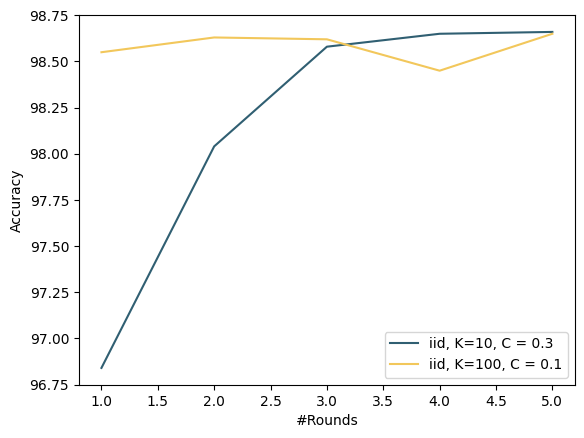

In [53]:
rounds = np.arange(5) + 1
plt.plot(rounds, test_accuracy_k10_iid, color="#305f72", label='iid, K=10, C = 0.3')
plt.plot(rounds, test_accuracy_k100_iid, color="#F2C75B", label='iid, K=100, C = 0.1')

plt.xlabel("#Rounds")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Question** : Que remarquez vous ?    ***(1 pt)***   
**Réponse** :
Le graphe en bleu représente l'utilisation de 10 clients avec 3 clients par tour, tandis que le graphe jaune illustre l'utilisation de 100 clients avec 10 clients par tour. Les deux graphes convergent lorsque les données sont indépendantes et identiquement distribuées (IID).

Le graphe jaune atteint une convergence plus rapide en raison du nombre important de clients initiale, cependant, l'accuracy demeure limitée. En revanche, le graphe bleu présente une augmentation progressive de l'accuracy au fil des itérations. Finalement, après un nombre suffisant d'itérations, l'accuracy du graphe bleu parvient à égaler celle du graphe jaune.

## 8.2 données non IID

Entrainons notre algorithme sur un environnement avec 10 clients et C = 0.3 (Fraction des clients sélectionnées à chaque tour) :

In [54]:
time_list_non_iid = []

In [55]:
model3 = CNN(num_channels =1,  out_channels1=6, out_channels2 = 16, num_classes = 10)

# Create the server object
server_k10_non_iid = Server(num_clients = 10, global_model = model3, dict_clients = dict_users_non_iid, loss_fct =  nn.CrossEntropyLoss(),  B = 50, dataset_test = dataset_test)

# Lancement de FedAVG
temps_debut = timeit.default_timer()
global_model_k10_non_iid , test_accuracy_k10_non_iid , loss_k10_non_iid = server_k10_non_iid.global_train(comms_round = 5,  lr = 0.01, momt = 0.8, C = 0.3, E = 5, mu =0,verbose_test = 1, verbose = 0)
temps_fin = timeit.default_timer() - temps_debut
time_list_non_iid.append(temps_fin)


# Cela peut prendre du Temps

Tour d'entrainement n : 1 , Test accuarcy :  42.27 , Test loss : 2.147727626800537
*************************************************************************************
Tour d'entrainement n : 2 , Test accuarcy :  31.47 , Test loss : 2.248576501464844
*************************************************************************************
Tour d'entrainement n : 3 , Test accuarcy :  25.29 , Test loss : 2.821478108215332
*************************************************************************************
Tour d'entrainement n : 4 , Test accuarcy :  39.59 , Test loss : 3.3844213470458984
*************************************************************************************
Tour d'entrainement n : 5 , Test accuarcy :  44.7 , Test loss : 1.7277204895019531
*************************************************************************************


In [56]:
model4 = CNN(num_channels =1,  out_channels1=6, out_channels2 = 16, num_classes = 10)

# Create the server object
server_k10_non_iid_prox = Server(num_clients = 10, global_model = model4, dict_clients = dict_users_non_iid, loss_fct =  nn.CrossEntropyLoss(),  B = 50, dataset_test = dataset_test)

# Lancement de FedAVG
temps_debut = timeit.default_timer()
global_model_k10_non_iid_prox , test_accuracy_k10_non_iid_prox , loss_k10_non_iid_prox = server_k10_non_iid_prox.global_train(comms_round = 5,  lr = 0.01, momt = 0.8, C = 0.3, E = 5, mu =1,verbose_test = 1, verbose = 0)
temps_fin = timeit.default_timer() - temps_debut
time_list_non_iid.append(temps_fin)


# Cela peut prendre du Temps

Tour d'entrainement n : 1 , Test accuarcy :  30.64 , Test loss : 2.176297622680664
*************************************************************************************
Tour d'entrainement n : 2 , Test accuarcy :  25.92 , Test loss : 2.1498023834228515
*************************************************************************************
Tour d'entrainement n : 3 , Test accuarcy :  20.95 , Test loss : 2.627139582824707
*************************************************************************************
Tour d'entrainement n : 4 , Test accuarcy :  39.02 , Test loss : 2.904259194946289
*************************************************************************************
Tour d'entrainement n : 5 , Test accuarcy :  45.51 , Test loss : 1.5715747978210448
*************************************************************************************


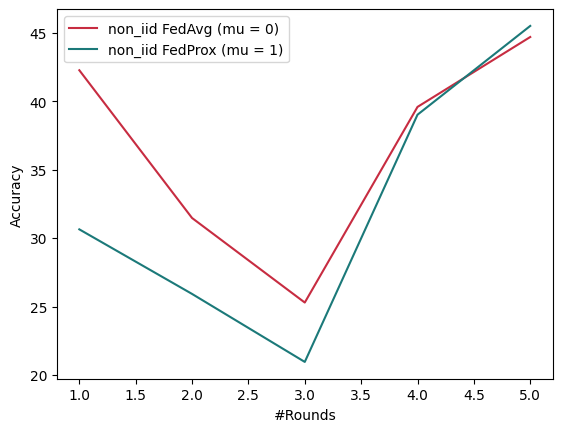

In [57]:
plt.plot(rounds, test_accuracy_k10_non_iid, color="#C72C41", label='non_iid FedAvg (mu = 0)')
plt.plot(rounds, test_accuracy_k10_non_iid_prox, color="#1B7979", label='non_iid FedProx (mu = 1)')

plt.xlabel("#Rounds")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Question** : Que remarquez vous ? ***(1 pt)***   
**Réponse** : Les deux méthodes ont donné de mauvais résultats en raison des données non iid au niveau des clients. Mais, Fedprox a donné de meilleurs résultats que Fedavg. parce que c'est une amélioration de FedAvg (mu)

In [63]:
pd.DataFrame({
    "Répartition" : ["iid", "iid", "non_iid", "non_idd"],
    "K" : [10, 100, 10, 10],
    "C" : [0.3, 0.1, 0.3, 0.3],
    "Test Accuracy" : [float(test_accuracy_k10_iid[4]), float(test_accuracy_k100_iid[4]), float(test_accuracy_k10_non_iid[4]), float(test_accuracy_k10_non_iid_prox[4])],
    "Time" : [time_list_iid[0], time_list_non_iid[1], time_list_non_iid[0], time_list_non_iid[1]]
})

,Répartition,K,C,Test Accuracy,Time
0,iid,10,0.3,98.660004,171.665802
1,iid,100,0.1,98.650002,186.874701
2,non_iid,10,0.3,44.700001,183.148169
3,non_idd,10,0.3,45.509998,186.874701


**Question** : Pourquoi FedAvg avec 10 clients prends plus de temps que FedAvg avec 100 cliens dans des données idd (un simple calcul mathétmatique) ? ***(1.5 pt)***     
**Réponse** :
- Étant donné que les données sont indépendantes et identiquement distribuées (IID), tous les clients partagent la même charge de travail. Par conséquent, l'algorithme FedAvg avec 100 clients sera plus rapide, car chaque client a une quantité moindre de données à traiter. Cela s'explique par le fait que FedAvg doit attendre que tous les clients aient terminé le calcul de leurs pertes individuelles avant de pouvoir calculer la moyenne des pertes.

  La charge de travail pour chaque client est définie comme Données/(C*K), où C est le nombre de clients et K est le nombre d'itérations. Ainsi, dans le cas de 10 clients avec C=0.3, le temps nécessaire sera plus élevé que celui pour 100 clients avec C=0.1, car la charge de travail par client sera plus importante pour le scénario avec 10 clients lors de l'utilisation de FedAvg.



# Conclusion

**Question** : Nous remarquons que même si nous utilisons d'autres techniques comme FedProx, la performance de l'apprentissage fédéré dans les environnements hétérogènes reste limitée. C'est pourquoi d'autres techniques intelligentes ont été proposées. Nommez deux d'entre elles et comment peuvent-elles être utilisées ?***(1.5 pt)***    


**Réponse** :
- Utilisation de l'apprentissage fédéré via le renforcement pour améliorer la convergence et assurer la stabilité.
  
-  transfert learning des poids d'un client à des données différentes, avec une immobilisation des dernières couches.

- Groupement des clients en communauté selon la similitude de leurs dataset.